<a href="https://colab.research.google.com/github/a8252525/detectron2_example_PCBdata/blob/master/PCBdata_fasterRCNN_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

You can check [here](https://github.com/facebookresearch/detectron2/blob/master/INSTALL.md) to get needed environment, but you don't need to worry it in colab.

In [0]:
!pip install -U torch==1.4.0 torchvision==0.5.0 cython fvcore Pillow==6.2.2 pyyaml==5.1
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
import torch, torchvision
torch.__version__

     |████████████████████████████████| 753.4MB 22kB/s 
     |████████████████████████████████| 4.0MB 36.8MB/s 
Requirement already up-to-date: cython in /usr/local/lib/python3.6/dist-packages (0.29.14)
Requirement already up-to-date: Pillow==6.2.2 in /usr/local/lib/python3.6/dist-packages (6.2.2)
     |████████████████████████████████| 276kB 57.4MB/s 
  Created wheel for fvcore: filename=fvcore-0.1.dev200114-cp36-none-any.whl size=30376 sha256=eda7df363fbfa0404ea2a841b05d7bb0ba7d7c7976ba370530806153b4084c53
  Stored in directory: /root/.cache/pip/wheels/31/52/ce/158c59c47690d60a76878c7b09d3e660fbfb091acbc02e6da3
  Created wheel for pyyaml: filename=PyYAML-5.3-cp36-cp36m-linux_x86_64.whl size=44229 sha256=2651176cac267701c6f3b286b7c6d56175aaaa85f513cb03b281222a7ad41963
  Stored in directory: /root/.cache/pip/wheels/e4/76/4d/a95b8dd7b452b69e8ed4f68b69e1b55e12c9c9624dd962b191
Successfully built fvcore pyyaml
  Found existing installation: torch 1.3.1
    Uninstalling torch-1.3.1:
      S

'1.4.0'

In [0]:
!git clone https://github.com/facebookresearch/detectron2
!git clone https://github.com/tangsanli5201/DeepPCB

Cloning into 'detectron2'...
remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 2439 (delta 0), reused 1 (delta 0), pack-reused 2432
Receiving objects: 100% (2439/2439), 1.86 MiB | 3.83 MiB/s, done.
Resolving deltas: 100% (1623/1623), done.
Cloning into 'DeepPCB'...
remote: Enumerating objects: 4753, done.
remote: Total 4753 (delta 0), reused 0 (delta 0), pack-reused 4753
Receiving objects: 100% (4753/4753), 85.81 MiB | 9.40 MiB/s, done.
Resolving deltas: 100% (191/191), done.


In [0]:
!ls
%cd detectron2/
!pwd
!pip install -e .
#It may need to restart runtime. Don't worry.

DeepPCB  detectron2  sample_data
/content/detectron2
/content/detectron2
Obtaining file:///content/detectron2
     |████████████████████████████████| 61kB 5.1MB/s 
  Found existing installation: tqdm 4.28.1
    Uninstalling tqdm-4.28.1:
      Successfully uninstalled tqdm-4.28.1
  Running setup.py develop for detectron2


In [0]:
# You may need to restart your runtime prior to this, to let your installation take effect
# Some basic setup
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
import random
#from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

In [0]:
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from matplotlib.pyplot import imshow
from PIL import Image
import IPython
def cv2_imshow(img):
    img = img[:,:,[2,1,0]]
    img = Image.fromarray(img)
    plt.figure(figsize=(20, 20))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

We have to take the data out from the .txt file.

In [0]:
import csv
train, test = [],[]
def take_path(x,d):
    with open(d) as t:
        #print(t.read())
        #print(type(csv.reader(t)))
        tmp = csv.reader(t,delimiter=' ')
        for i in tmp:
            x.append(i)
        for ele in x:
            ele[0] = '../DeepPCB/PCBData/'+ele[0][:-4]+'_test.jpg'
            ele[1] = '../DeepPCB/PCBData/'+ele[1]

take_path(test,'../DeepPCB/PCBData/test.txt')
print(test[:2])
take_path(train,'../DeepPCB/PCBData/trainval.txt')
print(train[:2])


[['../DeepPCB/PCBData/group20085/20085/20085291_test.jpg', '../DeepPCB/PCBData/group20085/20085_not/20085291.txt'], ['../DeepPCB/PCBData/group20085/20085/20085292_test.jpg', '../DeepPCB/PCBData/group20085/20085_not/20085292.txt']]
[['../DeepPCB/PCBData/group20085/20085/20085000_test.jpg', '../DeepPCB/PCBData/group20085/20085_not/20085000.txt'], ['../DeepPCB/PCBData/group20085/20085/20085001_test.jpg', '../DeepPCB/PCBData/group20085/20085_not/20085001.txt']]


In [0]:
height, width = cv2.imread(test[0][0]).shape[:2]
print(height, width)


640 640


In [0]:
import os
import numpy as np
import json
from detectron2.structures import BoxMode

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

#DatasetCatalog.clear()
#If you want to clear the data you registered, uncomment the upper line.

def get_PCB_dict(data_list):
    dataset_dicts = []
    
    for i,path in enumerate(data_list):
        filename = path[0]
        height, width = cv2.imread(filename).shape[:2]
        record = {}
        record['file_name'] = filename
        record['image_id'] = i
        record['height']= height
        record['width']= width
        
        
        objs = []
        with open(path[1]) as t:
            lines = t.readlines()
            for line in lines:
                if line[-1]=="\n":
                  box = line[:-1].split(' ')
                else:
                  box = line.split(' ')


                boxes = list(map(float,[box[0],box[1],box[2],box[3]]))
                category = int(box[4])

                obj = {
                    "bbox": boxes,
                    "bbox_mode": BoxMode.XYXY_ABS,
                    #"segmentation": [poly], To draw a line, along to ballon
                    #you will need this for mask RCNN
                    "category_id": category-1,
                    "iscrowd": 0
                }
                objs.append(obj)
            record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts #list of dicts

In [0]:
from detectron2.data import DatasetCatalog, MetadataCatalog
for d,x in [("train",train), ("test",test)]:
    DatasetCatalog.register("PCB_" + d, lambda x=x: get_PCB_dict(x))
    MetadataCatalog.get("PCB_" + d).set(thing_classes=["open", "short", "mousebite", "spur", "copper", "pin-hole"],thing_colors=[(255,0,0),(0,255,0),(0,0,255),(255,255,0),(255,0,255),(0,255,255)])
    #I set the colors, but it's no use. Retry after training.
PCB_metadata = MetadataCatalog.get("PCB_train")

In [0]:
#check dataset
print(type(PCB_metadata))
MetadataCatalog.get("PCB_test")

<class 'detectron2.data.catalog.Metadata'>


Metadata(name='PCB_test', thing_classes=['open', 'short', 'mousebite', 'spur', 'copper', 'pin-hole'], thing_colors=[(255, 0, 0), (0, 255, 0), (0, 0, 255), (255, 255, 0), (255, 0, 255), (0, 255, 255)])

Get all the data and check the content inside

In [0]:
dataset_dicts = get_PCB_dict(train)

In [0]:
print(dataset_dicts[0])
print(dataset_dicts[1])

{'file_name': '../DeepPCB/PCBData/group20085/20085/20085000_test.jpg', 'image_id': 0, 'height': 640, 'width': 640, 'annotations': [{'bbox': [409.0, 394.0, 435.0, 422.0], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'category_id': 2, 'iscrowd': 0}, {'bbox': [275.0, 383.0, 319.0, 417.0], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'category_id': 2, 'iscrowd': 0}, {'bbox': [8.0, 163.0, 36.0, 191.0], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'category_id': 3, 'iscrowd': 0}, {'bbox': [244.0, 151.0, 270.0, 182.0], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'category_id': 4, 'iscrowd': 0}, {'bbox': [338.0, 519.0, 364.0, 543.0], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'category_id': 5, 'iscrowd': 0}, {'bbox': [476.0, 460.0, 502.0, 481.0], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'category_id': 3, 'iscrowd': 0}]}
{'file_name': '../DeepPCB/PCBData/group20085/20085/20085001_test.jpg', 'image_id': 1, 'height': 640, 'width': 640, 'annotations': [{'bbox': [335.0, 208.0, 364.0, 233.0], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'category_id': 2,

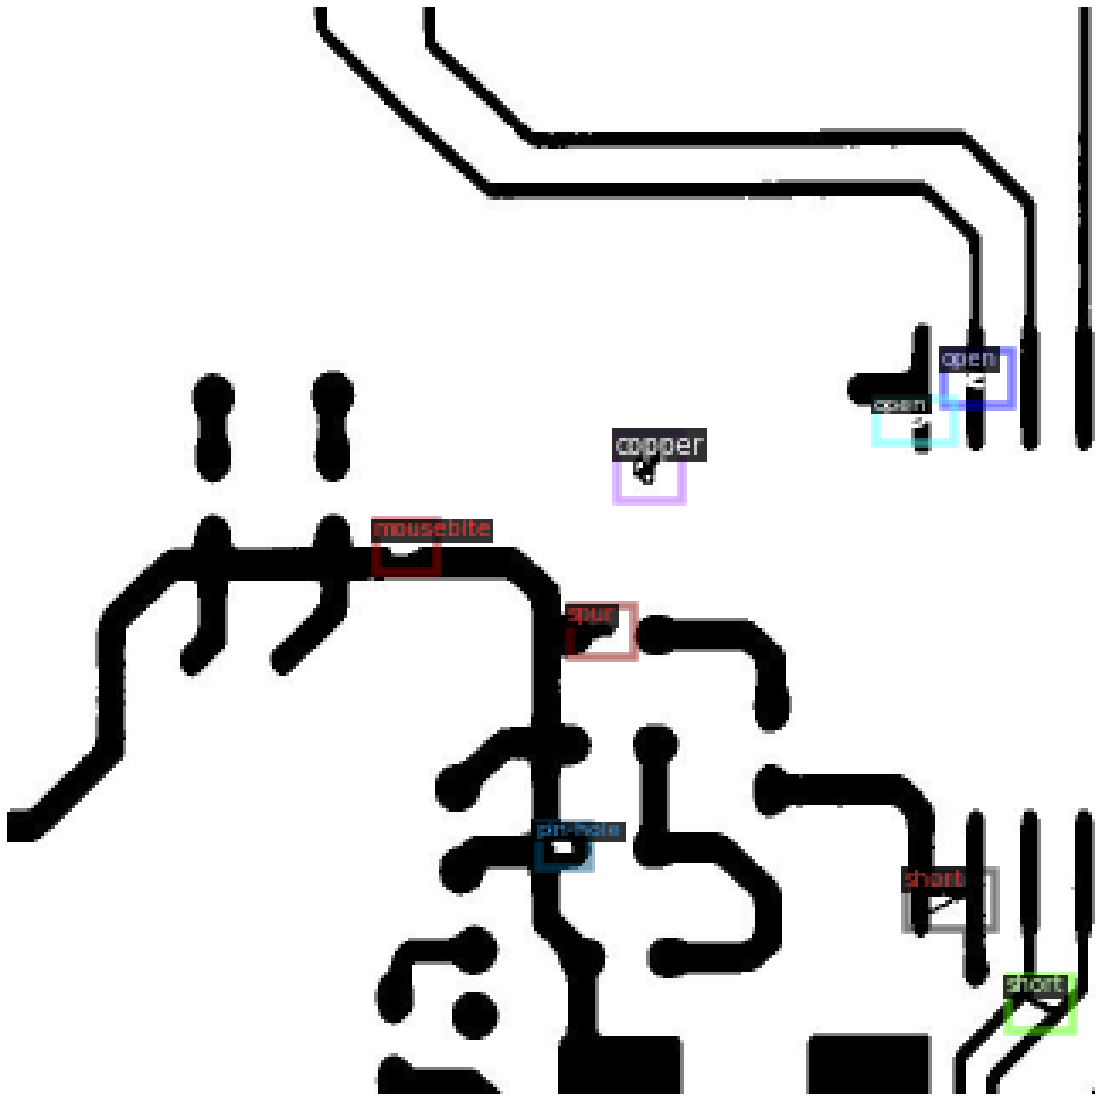

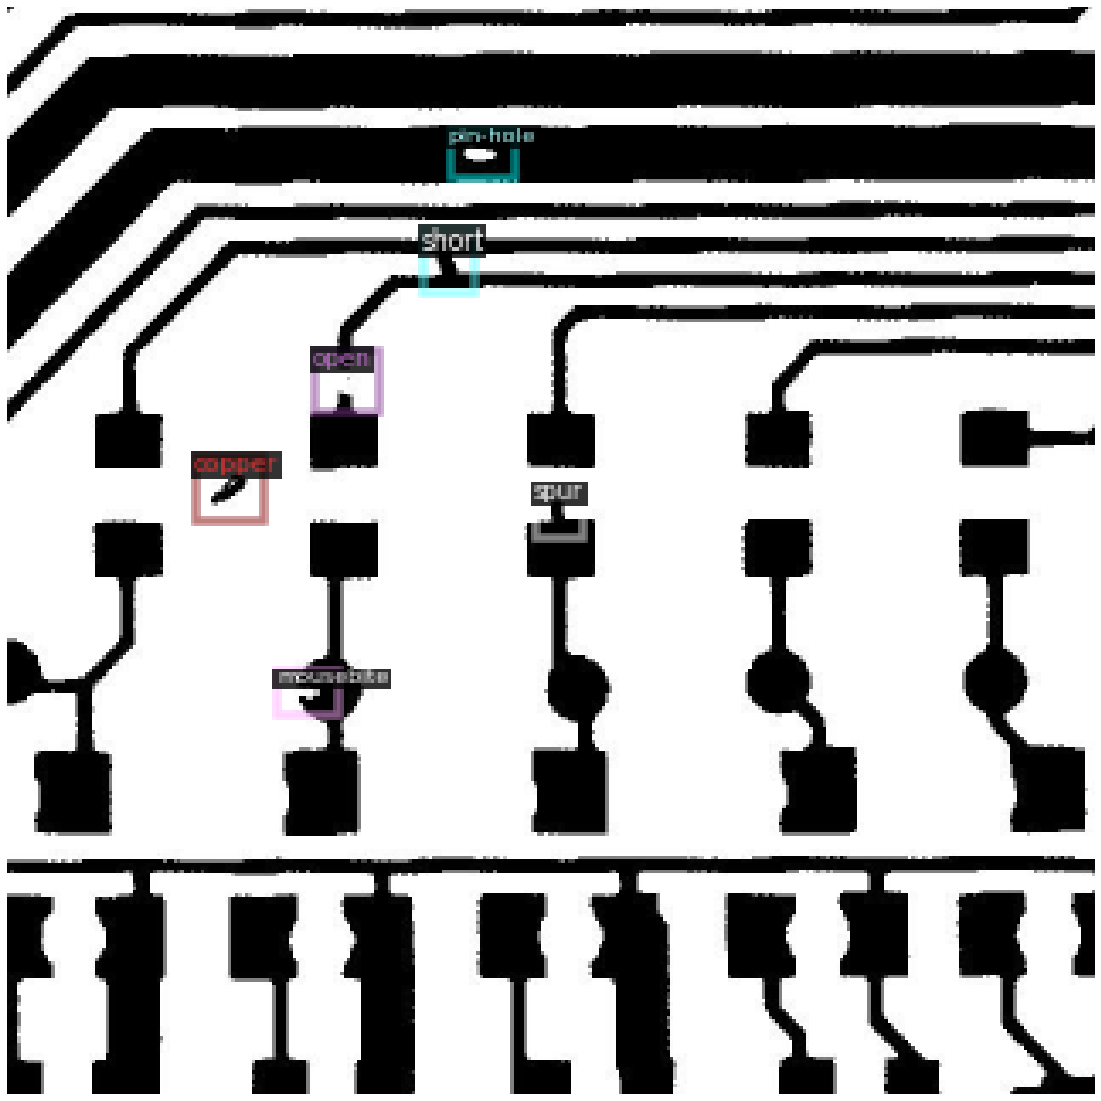

In [0]:
for d in random.sample(dataset_dicts, 2):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=PCB_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

In [0]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("PCB_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 0
cfg.MODEL.WEIGHTS = "detectron2://COCO-Detection/faster_rcnn_R_50_FPN_3x/137849458/model_final_280758.pkl"  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 3000    # 300 iterations seems good enough for this toy dataset; you may need to train longer for a practical dataset
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 4096   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 6 

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()
#It will train about 20 minutes in colab.

[01/16 06:26:50 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_280758.pkl: 167MB [00:16, 10.2MB/s]                           
'roi_heads.box_predictor.cls_score.weight' has shape (81, 1024) in the checkpoint but (7, 1024) in the model! Skipped.
'roi_heads.box_predictor.cls_score.bias' has shape (81,) in the checkpoint but (7,) in the model! Skipped.
'roi_heads.box_predictor.bbox_pred.weight' has shape (320, 1024) in the checkpoint but (24, 1024) in the model! Skipped.
'roi_heads.box_predictor.bbox_pred.bias' has shape (320,) in the checkpoint but (24,) in the model! Skipped.


[01/16 06:27:14 d2.engine.train_loop]: Starting training from iteration 0
[01/16 06:27:19 d2.utils.events]: eta: 0:13:03  iter: 19  total_loss: 2.677  loss_cls: 2.049  loss_box_reg: 0.040  loss_rpn_cls: 0.413  loss_rpn_loc: 0.135  time: 0.2620  data_time: 0.0889  lr: 0.000005  max_mem: 1832M
[01/16 06:27:25 d2.utils.events]: eta: 0:13:05  iter: 39  total_loss: 2.359  loss_cls: 1.833  loss_box_reg: 0.025  loss_rpn_cls: 0.327  loss_rpn_loc: 0.141  time: 0.2704  data_time: 0.0869  lr: 0.000010  max_mem: 1832M
[01/16 06:27:30 d2.utils.events]: eta: 0:13:08  iter: 59  total_loss: 1.860  loss_cls: 1.471  loss_box_reg: 0.032  loss_rpn_cls: 0.259  loss_rpn_loc: 0.145  time: 0.2735  data_time: 0.1007  lr: 0.000015  max_mem: 1832M
[01/16 06:27:36 d2.utils.events]: eta: 0:13:00  iter: 79  total_loss: 1.326  loss_cls: 0.954  loss_box_reg: 0.034  loss_rpn_cls: 0.203  loss_rpn_loc: 0.130  time: 0.2721  data_time: 0.0885  lr: 0.000020  max_mem: 1832M
[01/16 06:27:41 d2.utils.events]: eta: 0:12:56  it

OrderedDict()

In [0]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set the testing threshold for this model
cfg.DATASETS.TEST = ("PCB_test", )
predictor = DefaultPredictor(cfg)

In [0]:
from detectron2.utils.visualizer import ColorMode
dataset_dicts = get_PCB_dict(test)

tensor([0, 4, 3, 2, 1, 5], device='cuda:0')
Boxes(tensor([[289.1584, 326.0847, 325.2099, 358.8866],
        [233.4901, 118.8735, 262.8138, 149.5809],
        [106.2966, 181.0337, 140.5350, 211.7205],
        [259.9618, 240.3079, 288.6585, 271.2735],
        [500.9987, 334.7750, 527.8199, 374.0154],
        [347.2850, 146.7405, 395.6854, 180.7809]], device='cuda:0'))


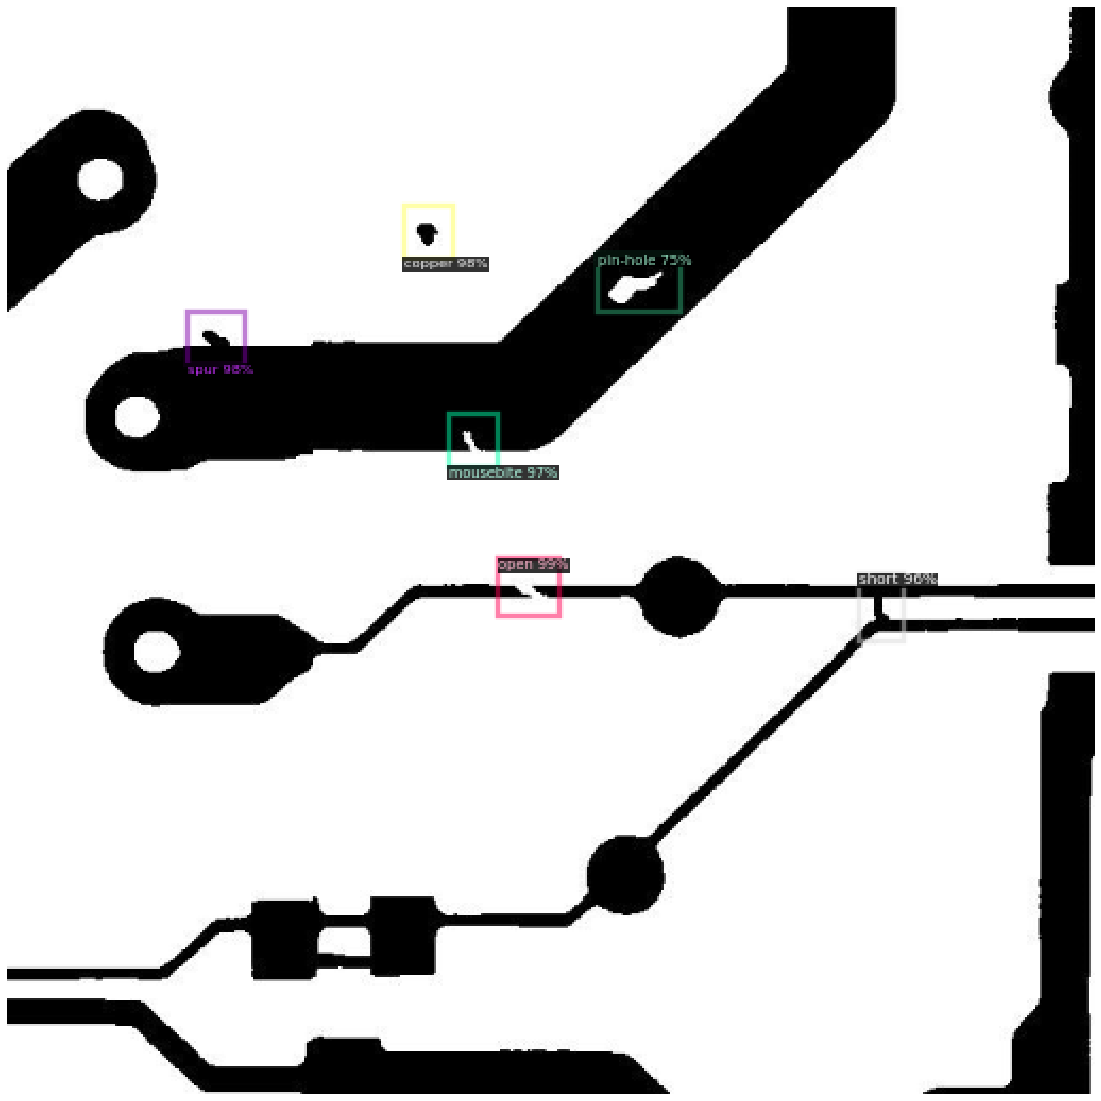

tensor([4, 0, 3, 1, 2, 5, 2, 1], device='cuda:0')
Boxes(tensor([[ 58.4175,  88.9920,  93.7996, 125.2564],
        [313.4500, 277.1244, 344.0853, 309.7951],
        [ 66.6329, 248.4785, 100.7439, 274.9893],
        [321.7696, 193.6610, 360.2889, 219.9511],
        [229.8293, 194.9907, 258.5093, 230.4802],
        [ 26.4428, 214.2391,  50.5354, 246.3053],
        [170.5833, 312.8182, 193.9772, 338.9754],
        [152.6880, 100.7127, 204.1657, 132.1025]], device='cuda:0'))


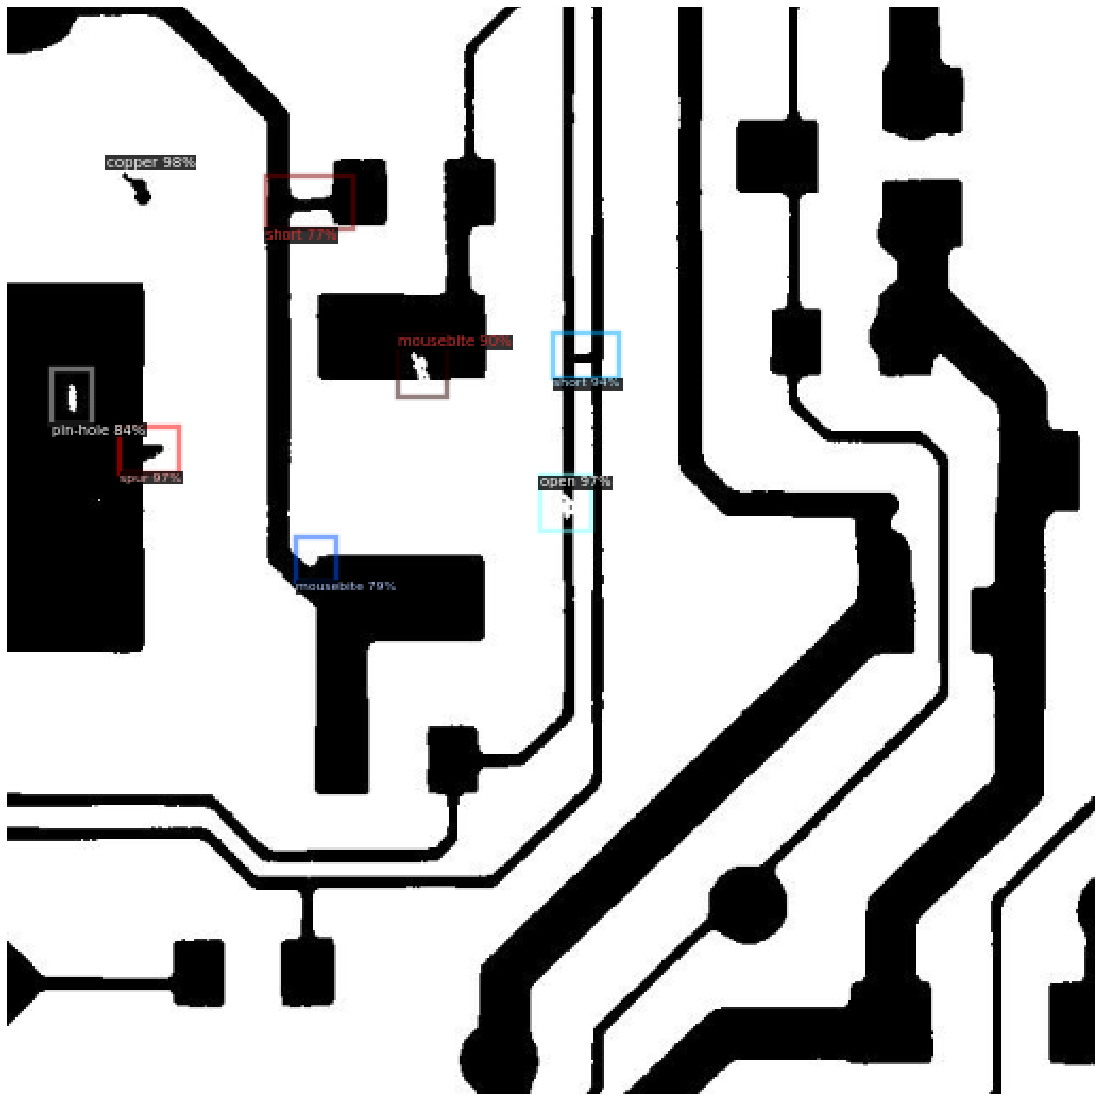

tensor([2, 0, 4, 1, 5, 3], device='cuda:0')
Boxes(tensor([[154.9577, 432.9809, 189.6112, 461.1192],
        [339.5444, 178.4696, 364.2066, 216.8975],
        [277.8615, 109.8881, 314.5492, 139.0469],
        [318.9588, 287.9915, 364.6136, 313.3003],
        [336.6411,   0.0000, 364.8897,  20.8363],
        [599.2099, 249.0496, 637.7070, 285.7413]], device='cuda:0'))


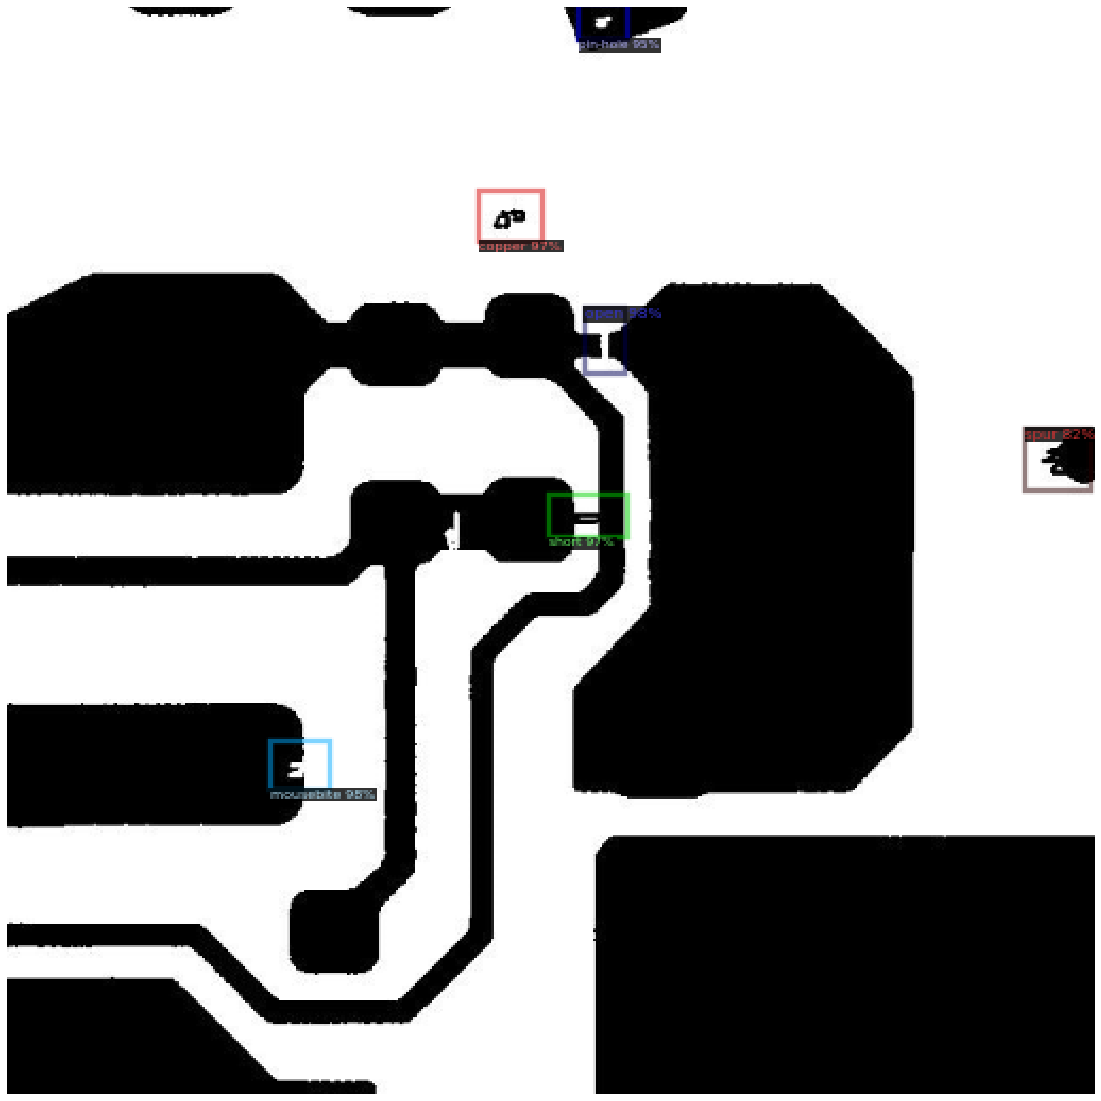

In [0]:
for d in random.sample(dataset_dicts, 3):
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im,
                   metadata=PCB_metadata, 
                   scale=0.8,
                   instance_mode =  ColorMode.IMAGE
        )
                   # remove the colors of unsegmented pixels
    print(outputs['instances'].pred_classes)
    print(outputs["instances"].pred_boxes)

    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(v.get_image())

In [0]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset, LVISEvaluator
from detectron2.data import build_detection_test_loader

evaluator = COCOEvaluator("PCB_test", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "PCB_test")
inference_on_dataset(trainer.model, val_loader, evaluator)
# another equivalent way is to use trainer.test

WARNING [01/16 06:41:10 d2.evaluation.coco_evaluation]: json_file was not found in MetaDataCatalog for 'PCB_test'
[01/16 06:41:10 d2.data.datasets.coco]: Converting dataset annotations in 'PCB_test' to COCO format ...)
[01/16 06:41:12 d2.data.datasets.coco]: Converting dataset dicts into COCO format
[01/16 06:41:12 d2.data.datasets.coco]: Conversion finished, num images: 500, num annotations: 3140
[01/16 06:41:12 d2.data.datasets.coco]: Caching annotations in COCO format: ./output/PCB_test_coco_format.json
[01/16 06:41:14 d2.data.build]: Distribution of instances among all 6 categories:
|  category  | #instances   |  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-------------|:----------:|:-------------|
|    open    | 659          |   short    | 478          | mousebite  | 586          |
|    spur    | 483          |   copper   | 464          |  pin-hole  | 470          |
|            |              |            |              |     

OrderedDict([('bbox',
              {'AP': 64.31825163056139,
               'AP-copper': 77.72030131795276,
               'AP-mousebite': 63.177111687191676,
               'AP-open': 59.407758192556805,
               'AP-pin-hole': 69.45151146413728,
               'AP-short': 50.63100208959249,
               'AP-spur': 65.52182503193735,
               'AP50': 93.13612566723208,
               'AP75': 79.45463612126157,
               'APl': 69.99999999999999,
               'APm': 65.48557070350444,
               'APs': 62.997574669449286})])